In [1]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Tuple
import seaborn as sn

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from prometheus_api_client import MetricSnapshotDataFrame, MetricRangeDataFrame, PrometheusConnect
from prometheus_api_client.utils import parse_datetime
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5


warnings.filterwarnings('ignore')


load_dotenv()

True

In [2]:
class BtalertIA:
    def __init__(self, last_minutes_importance: int, regressor=None) -> None:
        """
        Args:
            last_minutes_importance (int): The last minutes that matter to foreacasting (context)
        """
        self.prom = PrometheusConnect(
            url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)
        self.regressor = regressor
        if regressor is None:
            self.regressor = RandomForestRegressor(
                max_depth=40,
                n_estimators=3,
                random_state=123,
            )
        self.forecaster = ForecasterAutoreg(
            regressor=self.regressor,
            lags=self.minutes_to_step(last_minutes_importance)
        )
        self.original_dataframe = pd.DataFrame()
        self.data_train = pd.DataFrame()
        self.data_test = pd.DataFrame()
        self.predictions = pd.Series()
        self.value_column = 'value'
        self.timestamp_column = 'timestamp'

    def load_metric_as_dataframe(self, start: str, end: str, metric_name: str, alias: str) -> pd.DataFrame:
        start_time = parse_datetime(start)
        end_time = parse_datetime(end)
        original_dataframe = MetricRangeDataFrame(
            self.prom.custom_query_range(
                query=metric_name, start_time=start_time, end_time=end_time, step=15)
        )[['value']]

        original_dataframe['value'] = [
            float(value) for value in original_dataframe['value']]
        
        original_dataframe.rename(columns={'value': alias}, inplace=True)
        self.value_column = alias

        self.original_dataframe = original_dataframe
        return original_dataframe

    def split_test_train_dataframe(self, minutes_split: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        steps = self.minutes_to_step(minutes_split)

        self.data_train = self.original_dataframe[:-steps]
        self.data_test = self.original_dataframe[-steps:]

        return self.data_train, self.data_test

    def minutes_to_step(self, min: int) -> int:
        return int((min * 60) / 15)

    def train_model(self) -> None:
        self.forecaster.fit(y=self.data_train[self.value_column])

    def predict(self, minutes_prediction: int) -> pd.Series:
        self.predictions = self.forecaster.predict(steps=self.minutes_to_step(minutes_prediction))
        return self.predictions

    def plot_graphic(self):
        fig, ax = plt.subplots(figsize=(18, 12))
        self.data_train[self.value_column].plot(ax=ax, label='train')
        self.data_test[self.value_column].plot(ax=ax, label='test')
        self.predictions.plot(ax=ax, label='predictions')
        ax.legend()

    def get_mean_squared_error(self) -> float:
        error_mse: float = mean_squared_error(
            y_true=self.data_test[self.value_column],
            y_pred=self.predictions
        )
        return error_mse

    def execute(self, start: str, end: str, metric_name: str, minutes_split: int, minutes_prediction: int, alias: str):
        self.load_metric_as_dataframe(start, end, metric_name, alias)
        self.split_test_train_dataframe(minutes_split)
        self.train_model()
        self.predict(minutes_prediction)
# consts
#start = '2022-05-11 07:50:07'
end = '2022-05-11 10:47:27'
start = '2022-05-11 09:53:16'
#end = '2022-05-11 08:03:53'
min_split = 25
# teste
req_failed_ia = BtalertIA(20)

In [2]:
df = pd.read_csv('data/all_sample.csv', delimiter=';')
df['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in df['timestamp']]
df = df.set_index(df['timestamp'])
df = df.asfreq(freq='15S', method='bfill')
df.drop(columns='timestamp', inplace=True)

In [3]:
#res.to_csv('dados.csv', sep=';', encoding='utf-8')
df

,req_failed,request_per_sec,cpu_percent,memory_percent
timestamp,,,,
2022-05-11 07:50:07,0.00,0.00,0.000286,0.681229
2022-05-11 07:50:22,0.00,0.80,0.022767,0.740280
2022-05-11 07:50:37,0.00,12.07,0.065587,0.783585
2022-05-11 07:50:52,0.00,15.27,0.116834,0.881149
2022-05-11 07:51:07,0.00,20.93,0.172781,0.863525
...,...,...,...,...
2022-05-11 10:46:07,99.98,0.00,NaN,NaN
2022-05-11 10:46:22,99.98,0.00,NaN,NaN
2022-05-11 10:46:37,99.98,0.00,NaN,NaN


In [5]:
corr = df.corr()
corr

,req_failed,request_per_sec,cpu_percent,memory_percent
req_failed,1.000000,-0.648486,-0.497337,-0.504827
request_per_sec,-0.648486,1.000000,0.902064,0.367997
cpu_percent,-0.497337,0.902064,1.000000,0.340265
memory_percent,-0.504827,0.367997,0.340265,1.000000


<AxesSubplot:>

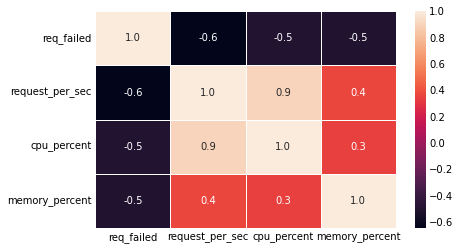

In [6]:
plot = sn.heatmap(corr, annot=True, fmt='0.1f', linewidths=.6)
plot

### Lendo dados salvos

In [7]:
dados = pd.read_csv('data/future_sample.csv', delimiter=';', usecols=['cpu_percent', 'timestamp'])
dados['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in dados['timestamp']]
dados = dados.set_index(dados['timestamp'])
dados = dados.asfreq(freq='15S', method='bfill')

In [8]:
dados.isnull()
dados.fillna(0, inplace=True)
#dados.isnull()

In [9]:
def minutes_to_step(min: int) -> int:
        return int((min * 60) / 15)

regressor = RandomForestRegressor(
                max_depth=20,
                n_estimators=3,
                random_state=123,
            )

In [10]:
dados = dados.drop(columns='timestamp')

### Gráfico dos dados de requisições falhadas, uso de CPU(%) e uso de memória(%) dos dados coletados

In [11]:
'''fig, ax = plt.subplots(figsize=(24, 12))
dados['cpu_percent'].plot(ax=ax, label='cpu_percent')
#dados['cpu_percent'].plot(ax=ax, label='cpu_percent')
#dados['memory_percent'].plot(ax=ax, label='memory_percent')

ax.legend(prop={'size': 25})
#dados.plot()'''

"fig, ax = plt.subplots(figsize=(24, 12))\ndados['cpu_percent'].plot(ax=ax, label='cpu_percent')\n#dados['cpu_percent'].plot(ax=ax, label='cpu_percent')\n#dados['memory_percent'].plot(ax=ax, label='memory_percent')\n\nax.legend(prop={'size': 25})\n#dados.plot()"

In [12]:
split_time = minutes_to_step(10)
train = dados[:-split_time]
test = dados[-split_time:]

In [13]:
print(len(train), len(test))
#print(train.head())

152 40


In [14]:
predictions = {}
#for label in ['req_failed', 'cpu_percent', 'memory_percent', 'request_per_sec']:
for label in ['cpu_percent']:
    forecaster = ForecasterAutoreg(
            regressor=regressor,
            lags=minutes_to_step(10)
        )
    forecaster.fit(y=train[label])
    prediction = forecaster.predict(steps=split_time)
    predictions[label] = prediction

### Gráfico comparativo da predição e dados reais do uso de CPU(%)

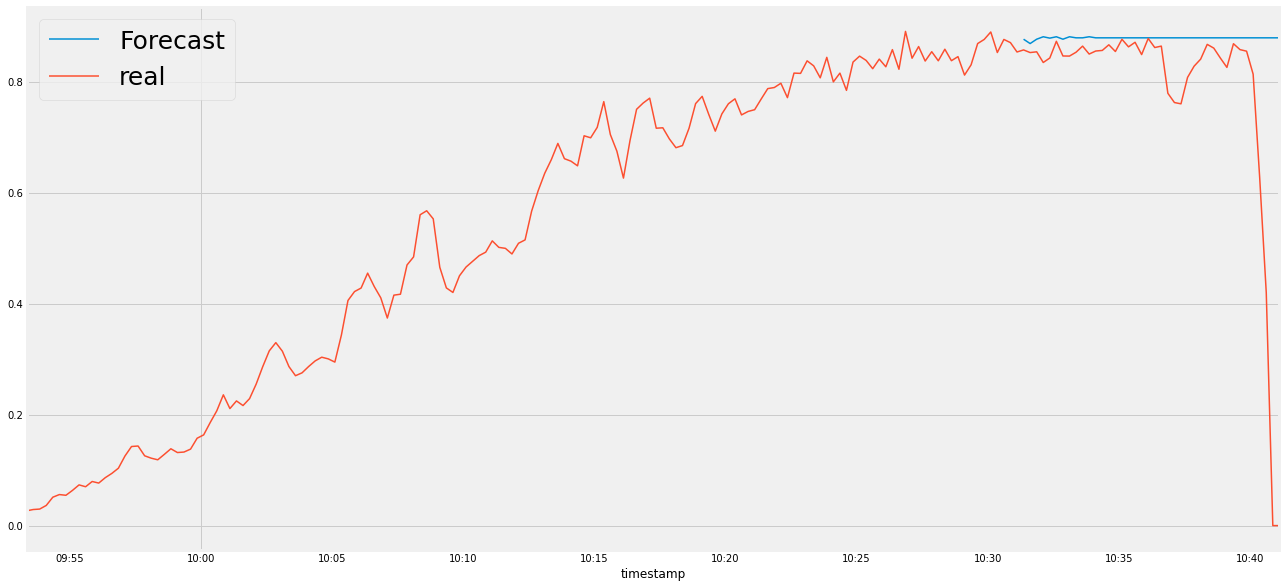

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
predictions['cpu_percent'].plot(ax=ax, label='Forecast')
dados['cpu_percent'].plot(ax=ax, label='real')
ax.legend(prop={'size': 25})

In [23]:
#start = '2022-05-24 17:39:11'
start = '2022-05-24 18:22:32'
#end = '2022-05-24 18:25:20'
end = 'now'
req_failed = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'req_failed')
requests_per_second = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_requests_per_second', 'request_per_sec')
pg_lock_count = req_failed_ia.load_metric_as_dataframe(start, end, 'pg_lock_count', 'lock_count')
max_cpu = req_failed_ia.load_metric_as_dataframe(start, end, 'max(rate(container_cpu_usage_seconds_total{image="api6-backend_cadastrol-server"}[1m:15s]))', 'cpu_percent')
memory = req_failed_ia.load_metric_as_dataframe(start, end, 'container_memory_rss{name="cadastrol-server"} / container_spec_memory_limit_bytes{name="cadastrol-server"}', 'memory_percent')

In [24]:
res = None
res = pd.concat([req_failed.reset_index(), requests_per_second.reset_index(), pg_lock_count.reset_index(), max_cpu.reset_index(), memory.reset_index()], axis=1)
res.head(10)

,timestamp,req_failed,timestamp,request_per_sec,timestamp,lock_count,timestamp,cpu_percent,timestamp,memory_percent
0,1.653425e+09,51.28,1.653425e+09,0.13,1653424751,0.0,1.653425e+09,0.000000,1.653426e+09,0.615631
1,1.653425e+09,51.28,1.653425e+09,0.13,1653424766,0.0,1.653425e+09,0.046254,1.653426e+09,0.651306
2,1.653425e+09,51.28,1.653425e+09,0.13,1653424781,0.0,1.653425e+09,0.046372,1.653426e+09,0.651306
3,1.653425e+09,51.28,1.653425e+09,0.13,1653424796,0.0,1.653425e+09,0.046372,1.653426e+09,0.651810
4,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424811,0.0,1.653425e+09,0.064571,1.653426e+09,0.651810
5,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424826,0.0,1.653425e+09,0.061743,1.653426e+09,0.651810
6,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424841,0.0,1.653425e+09,0.061743,1.653426e+09,0.657852
7,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424856,0.0,1.653425e+09,0.002641,1.653426e+09,0.673462
8,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424871,0.0,1.653425e+09,0.000000,1.653426e+09,0.698639
9,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424886,0.0,1.653425e+09,0.000000,1.653426e+09,0.716766


In [25]:
res.index = [datetime.fromtimestamp(int(data)) for data in res.iloc[:,4]]
res

,timestamp,req_failed,timestamp,request_per_sec,timestamp,lock_count,timestamp,cpu_percent,timestamp,memory_percent
2022-05-24 17:39:11,1.653425e+09,51.28,1.653425e+09,0.13,1653424751,0.0,1.653425e+09,0.000000,1.653426e+09,0.615631
2022-05-24 17:39:26,1.653425e+09,51.28,1.653425e+09,0.13,1653424766,0.0,1.653425e+09,0.046254,1.653426e+09,0.651306
2022-05-24 17:39:41,1.653425e+09,51.28,1.653425e+09,0.13,1653424781,0.0,1.653425e+09,0.046372,1.653426e+09,0.651306
2022-05-24 17:39:56,1.653425e+09,51.28,1.653425e+09,0.13,1653424796,0.0,1.653425e+09,0.046372,1.653426e+09,0.651810
2022-05-24 17:40:11,1.653425e+09,-0.00,1.653425e+09,-0.13,1653424811,0.0,1.653425e+09,0.064571,1.653426e+09,0.651810
...,...,...,...,...,...,...,...,...,...,...
2022-05-24 18:46:41,NaN,NaN,NaN,NaN,1653428801,0.0,NaN,NaN,NaN,NaN
2022-05-24 18:46:56,NaN,NaN,NaN,NaN,1653428816,0.0,NaN,NaN,NaN,NaN
2022-05-24 18:47:11,NaN,NaN,NaN,NaN,1653428831,0.0,NaN,NaN,NaN,NaN
2022-05-24 18:47:26,NaN,NaN,NaN,NaN,1653428846,0.0,NaN,NaN,NaN,NaN


In [26]:
res.drop(columns='timestamp', inplace=True)
res = res.fillna(0)
res

,req_failed,request_per_sec,lock_count,cpu_percent,memory_percent
2022-05-24 17:39:11,51.28,0.13,0.0,0.000000,0.615631
2022-05-24 17:39:26,51.28,0.13,0.0,0.046254,0.651306
2022-05-24 17:39:41,51.28,0.13,0.0,0.046372,0.651306
2022-05-24 17:39:56,51.28,0.13,0.0,0.046372,0.651810
2022-05-24 17:40:11,-0.00,-0.13,0.0,0.064571,0.651810
...,...,...,...,...,...
2022-05-24 18:46:41,0.00,0.00,0.0,0.000000,0.000000
2022-05-24 18:46:56,0.00,0.00,0.0,0.000000,0.000000
2022-05-24 18:47:11,0.00,0.00,0.0,0.000000,0.000000
2022-05-24 18:47:26,0.00,0.00,0.0,0.000000,0.000000


<AxesSubplot:>

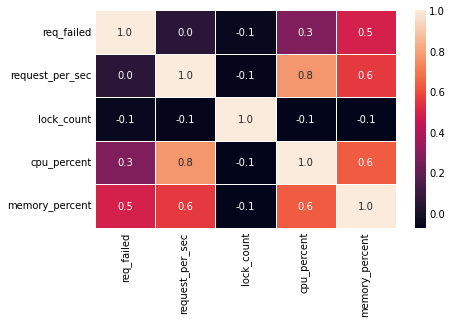

In [27]:
corr = res.corr()
plot = sn.heatmap(corr, annot=True, fmt='0.1f', linewidths=.6)
plot